# Aluno

Henrique Fürst Scheid - 2017014898

# Referências

Este trabalho utilizou dados retirados de https://phillipi.github.io/pix2pix/.
Para o tratamento dos dados e a implementação da rede consultaram-se os sites:
- https://www.tensorflow.org/tutorials/generative/pix2pix
- https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

Além disso, consultou-se o próprio artigo original da rede, [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004).

# Preâmbulo - bibliotecas e download dos dados

In [1]:
# Utilizar-se-ão os dados do trabalho https://phillipi.github.io/pix2pix/.
# Encontra-se no github do projeto um arquivo .sh com o download dos datasets,
# utilizado como referência para essa célula
!wget -N http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/cityscapes.tar.gz -O ./cityscapes.tar.gz
!mkdir -p ./datasets/cityscapes
!tar -zxvf ./cityscapes.tar.gz -C ./datasets
!rm cityscapes.tar.gz

for details.

--2024-08-12 03:01:16--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/cityscapes.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103441232 (99M) [application/x-gzip]
Saving to: ‘./cityscapes.tar.gz’

./cityscapes.tar.gz 100%[===================>]  98.65M   515KB/s    in 3m 22s  

2024-08-12 03:04:39 (500 KB/s) - ‘./cityscapes.tar.gz’ saved [103441232/103441232]

cityscapes/
cityscapes/train/
cityscapes/train/17.jpg
cityscapes/train/234.jpg
cityscapes/train/2970.jpg
cityscapes/train/1.jpg
cityscapes/train/10.jpg
cityscapes/train/100.jpg
cityscapes/train/1000.jpg
cityscapes/train/1001.jpg
cityscapes/train/1002.jpg
cityscapes/train/1003.jpg
cityscapes/train/1004.jpg
cityscapes/train/1005.jpg
cityscapes/train/1006.jpg
cityscapes/train/1007.jpg
cityscapes/train/1008.jp

In [2]:
from functools import reduce
from typing import Callable

import tensorflow as tf
import keras
from keras.preprocessing import image

import numpy as np

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

# Tratamento dos dados

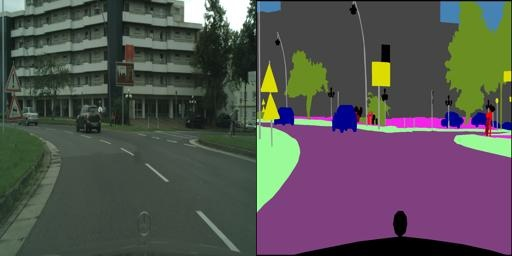

In [3]:
# Estudando os dados
sample = image.load_img('datasets/cityscapes/train/1.jpg', color_mode='rgb')
sample

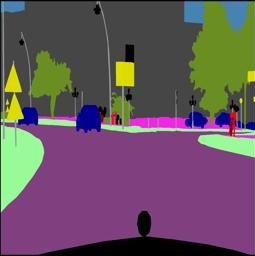

In [4]:
# A imagem já vem com seu par. Será necessário dividí-las no eixo X para obter o
# input e o output.

# Após a leitura, sempre trabalharemos com np.arrays. Dessa forma se reduz
# qualquer confusão de tipos.
def split_input_output(img:np.array) -> tuple[np.array, np.array]:
    shape_x, shape_y, shape_z = img.shape
    split_point = shape_y // 2
    return [
        img[:, 0:split_point, :],
        img[:, split_point:-1, :]
    ]

output, input = split_input_output(image.img_to_array(sample))
image.array_to_img(input)

In [5]:
# O pré-processamento definido no artigo é a aplicação de "tremor" (jittering),
# o espelhamento na imagem, ambos com frequência aletória. Tambem é feita a
# normailzação das imagens:

# Para se adicionar um "tremor" à foto, a imagem é ligeiramente expandida e um
# retalho seu é recortado aleatoriamente. Dessa forma tem-se uma imagem com as
# dimensões da imagem original, mas representando apenas um trecho recortado
# aleatoriamente.
def jitter(input_output:tuple[np.array,np.array]) -> tuple[np.array, np.array]:
    resized_input = image.smart_resize(input_output[0], (286, 286))
    resized_output = image.smart_resize(input_output[1], (286, 286))

    # O recorte deve ser semelhante para a imagem de entrada e a imagem-alvo.
    # Para isso, ambos são empilhados ao longo do eixo Z antes da operação,
    # para depois serem novamente separados.
    img_stack = tf.stack([resized_input, resized_output], axis=0)
    cropped_stack = tf.image.random_crop(img_stack, size=(2,256,256,3))
    return cropped_stack[0], cropped_stack[1]

def mirror(input_output:tuple[np.array,np.array]) -> tuple[np.array, np.array]:

    # Conforme o trabalho original, o espelhamento é feito aleatoriamente sobre
    # as imagens.
    if tf.random.uniform(()) <= 0.5:
        return input_output
    return (tf.image.flip_left_right(input_output[0]),
            tf.image.flip_left_right(input_output[1]))

# Em uma imagem RGB, todo pixel possui um valor entre [0, 255] para cada canal
# de cor. Desejamos normalizar toda imagem entre [-1,1].
def norm(input_output:tuple[np.array,np.array]) -> tuple[np.array, np.array]:
    input = (input_output[0] / 127.5) -1
    output = (input_output[1] / 127.5) -1
    return input, output

# A última transformação finalmente converte os np.arrays em tf.Tensor. Isso é
# necessário para o correto funcionamento dos modelos.
def to_tensor(input_output:tuple[np.array,np.array]) -> tuple[tf.Tensor, tf.Tensor]:
    input = tf.convert_to_tensor(input_output[0], dtype=tf.float32)
    output = tf.convert_to_tensor(input_output[1], dtype=tf.float32)
    return input, output

In [6]:
# Definimos agora a função que lê todo o dataset e gera o conjunto de inputs e
# outputs.

# Definimos um limite que trunca a leitura dos dados para
# agilizar testes.

# Finalmente, podemos passar uma série de funções a serem aplicadas sobre cada
# imagem antes de ser adicionada ao conjunto de inputs. As funções correspondem
# ao pré-processamento descrito na seção 6.2 do artigo do pix2pix:
# https://arxiv.org/pdf/1611.07004

def read_dataset(dir:str, limit:int=0, processing:list[Callable]=[]) -> tuple[list[tf.Tensor], list[tf.Tensor]]:
    # Lista o nome de todas as imagens no diretório (de teste ou treinamento)
    img_file_names = os.listdir(f'./datasets/cityscapes/{dir}')

    # Se não houver limite de imagens especificado, usar todas as imagens
    # do diretório
    if limit == 0:
        limit = len(img_file_names)

    inputs = []
    outputs = []
    for i in range(len(img_file_names)):
        # Truncar leitura
        if i > limit:
            break
        # Ler imagem
        img = image.load_img(
            f'./datasets/cityscapes/{dir}/{img_file_names[i]}',
            color_mode='rgb'
        )
        # Dividir imagem em input e output (imagem-alvo)
        output, input = split_input_output(image.img_to_array(sample))
        # Aqui se aplicam todas as funções de pré-processamento parametrizadas.
        input, output = reduce(
            lambda input_output, func: func(input_output),
            processing,
            (input,output)
        )
        inputs.append(input)
        outputs.append(output)
    return inputs, outputs

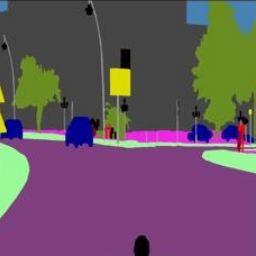

In [7]:
# Exemplo de leitura usando o pré-processamento do artigo:
inputs, outputs = read_dataset('train', 1, [jitter, mirror, norm, to_tensor])
image.array_to_img(inputs[0])

In [8]:
# Verificando o tipo da imagem
# (para evitar conflitos durante o treinamento do modelo)
type(inputs[0])

tensorflow.python.framework.ops.EagerTensor

# Implementando a GAN

## Estruturas auxiliares - blocos das redes

In [29]:
# Gera um "tijolo" da rede composto por uma camada convolucional,
# batch_normalization e ativação Leaky ReLU
def downsample_block(filters, kernel, batchnorm=True):
    #   initializer = tf.random_normal_initializer(0., 0.02)
    block = keras.Sequential()
    block.add(
        keras.layers.Conv2D(filters, kernel, strides=2, padding='same', use_bias=False)
    )
    if batchnorm:
        block.add(keras.layers.BatchNormalization())
    block.add(keras.layers.LeakyReLU())
    return block

# Analogamente, gera um "tijolo" da rede composto por uma camada convolucional,
# batch_normalization, dropout e ativação ReLU:
def upsample_block(filters, kernel, dropout=False):
    #   initializer = tf.random_normal_initializer(0., 0.02)
    block = keras.Sequential()
    block.add(
        keras.layers.Conv2DTranspose(filters, kernel, strides=2, padding='same', use_bias=False)
    )
    block.add(keras.layers.BatchNormalization())
    if dropout:
        block.add(keras.layers.Dropout(0.5))
    block.add(keras.layers.ReLU())
    return block

## Estruturas auxiliares - funções de perda e otimização

In [30]:
# Otimizador
generator_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)

# Perda global
# o objeto representando a Entropia Crusada é criado no escopo
# global pois é utilizado por ambas funções de perda do gerador
# e do discriminador
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    # A perda total do gerador combina a perda da GAN com o erro médio
    # absoluto da imagem gerada, se comparada à imagem-alvo.

    # Perda da GAN é dada pela entropia cruzada do output do discriminador:
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Erro médio absoluto
    l1_loss = tf.reduce_mean(abs(target - gen_output))

    # O erro total do gerador é dado pela fórmula:
    # erro da GAN + Lambda * perda L1
    # Os autores do trabalho original definem Lambda = 100
    total_gen_loss = gan_loss +  (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    # A perda do discriminiador soma a entropia cruzada de sua discriminação
    # para imagens reais e sua discriminação para imagens geradas pelo gerador.
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(
        tf.zeros_like(disc_generated_output),
        disc_generated_output
    )
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

## Gerador

In [20]:
# Utilizando as funções auxiliares para criar o gerador.
# A arquitetura do gerador é baseada na seção 3.2.1 do artigo original
# disponível em: https://arxiv.org/pdf/1611.07004

# Os autores do artigo defendem o uso de uma rede encoder-decoder baseado
# no uso de tais redes em trabalhos semelhantes. A codificação e decodificação
# da imagem faz com que a informação estrutural fundamental seja valorizada.

# No entanto, os autores afirmam que há a necessidade de preservar informação
# de baixo nível das imagens, como o posicionamento exato de bordas. Para esse
# fim adicionam-se skip-connections, de modo que as camadas da segunda metade
# da rede recebem a imagem total e parcialmente comprimida.

# Experimenta-se aqui a viabilidade de uma rede menor.
# Observou-se que resultados reconhecíveis são alcançáveis
# com menor dispêndio de recursos
# (menos de metade da rede originalmente proposta)

input_layer = keras.layers.Input(shape=[256,256,3])
downsampling = [
    downsample_block(64, 4, batchnorm=False), # 128
    downsample_block(128, 4), # 64
    downsample_block(128, 4), # 32
    downsample_block(256, 4), # 16
    # downsample_block(512, 4),
    # downsample_block(512, 4),
    # downsample_block(512, 4),
    # downsample_block(512, 4),
    # downsample_block(512, 4),
]

# Como se reduziu o número de camadas de downsampling, deve-se
# espelhar a redução para as camadas de upsampling.
upsampling = [
    # upsample_block(512, 4, dropout=True),
    # upsample_block(512, 4, dropout=True),
    # upsample_block(512, 4, dropout=True),
    # upsample_block(512, 4),
    upsample_block(256, 4), # 32
    upsample_block(128, 4), # 64
    upsample_block(64, 4), # 128
]
x = input_layer

# Skip connections entre camadas de downsampling e upsampling
skips = []
for down in downsampling:
    x = down(x)
    skips.append(x)

# não é necessário skip-connection da última camada, ela é o input
# da próxima
skips = reversed(skips[:-1])

for up, skip in zip(upsampling, skips):
    x = up(x)
    x = keras.layers.Concatenate()([x, skip])

# A última camada de upsampling usa a ativação de tangente hiperbólica
# para gerar pixels entre [-1, 1], nos três canais RGB,
# tal como a imagem de entrada.
last = keras.layers.Conv2DTranspose(3, 4,
                                    strides=2,
                                    padding='same',
                                    activation='tanh') # 256

x = last(x)

generator = keras.models.Model(inputs=input_layer, outputs=x)

In [21]:
# Visualizando a arquitetura resultante da rede
generator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 128, 128, 64)   │          3,072 │ input_layer_11[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 64, 64, 128)    │        131,584 │ sequential_10[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_12             │ (None, 32, 32, 128)    │        262,656 │ sequential_11[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_13             │ (None, 16, 16, 256)    │        525,312 │ sequential_12[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_14             │ (None, 32, 32, 256)    │      1,049,600 │ sequential_13[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 32, 32, 384)    │              0 │ sequential_14[0][0],   │
│ (Concatenate)             │                        │                │ sequential_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 64, 64, 128)    │        786,944 │ concatenate_4[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 64, 64, 256)    │              0 │ sequential_15[0][0],   │
│ (Concatenate)             │                        │                │ sequential_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 128, 128, 64)   │        262,400 │ concatenate_5[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 128, 128, 128)  │              0 │ sequential_16[0][0],   │
│ (Concatenate)             │                        │                │ sequential_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7        │ (None, 256, 256, 3)    │          6,147 │ concatenate_6[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,027,715 (11.55 MB)

 Trainable params: 3,025,795 (11.54 MB)

 Non-trainable params: 1,920 (7.50 KB)

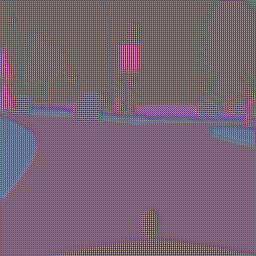

In [22]:
# Exemplo de resultado da rede geradora
gen_output = generator(inputs[0][tf.newaxis, ...], training=False)
image.array_to_img(gen_output[0, ...])

## Discriminador

In [23]:
# A rede discriminadora recebe tanto a imagem de input (abstração colorida)
# Quanto a imagem de output (imagem-alvo ou produto da rede geradora).
input_layer = keras.layers.Input(shape=(256,256,3), name='input')
output_layer = keras.layers.Input(shape=(256,256,3), name='outputs')

# Ambas imagens são postas lado-a-lado como no dataset original
x = keras.layers.Concatenate()([input_layer, output_layer])

x = downsample_block(64, 4, False)(x)
x = downsample_block(128, 4)(x)
x = downsample_block(256, 4)(x)

x = keras.layers.ZeroPadding2D()(x)
x = keras.layers.Conv2D(512, 4, strides=1, use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.ZeroPadding2D()(x)
x = keras.layers.Conv2D(1, 4, strides=1)(x)

# O output tem o formato 30 x 30, onde cada pixel classificica
# um retalho de 70 x 70 da imagem de input.

discriminator = keras.models.Model(inputs=[input_layer, output_layer], outputs=x)

In [24]:
discriminator.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputs (InputLayer)      │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 256, 256, 6)    │              0 │ input[0][0],           │
│ (Concatenate)             │                        │                │ outputs[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, 128, 128, 64)   │          6,144 │ concatenate_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_18             │ (None, 64, 64, 128)    │        131,584 │ sequential_17[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_19             │ (None, 32, 32, 256)    │        525,312 │ sequential_18[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 34, 34, 256)    │              0 │ sequential_19[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 31, 31, 512)    │      2,097,152 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 31, 31, 512)    │          2,048 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 31, 31, 512)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 33, 33, 512)    │              0 │ leaky_re_lu_15[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 30, 30, 1)      │          8,193 │ zero_padding2d_3[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [25]:
# Como as funções de perda dos modelos são correlacionadas, e como o treinamento
# de ambos é vinculado, o treinamento é definido manualmente ao invés de se
# utilizar uma função model.fit( )
def train_step(input, output):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Gere uma imagem com o input
        gen_output = generator(input, training=True)
        # Faça uma classificação para um input e o seu output verdadeiro
        disc_real_output = discriminator([input, output], training=True)
        # Faça uma classificação para o mesmo input e sua imagem gerada pelo gerador
        disc_generated_output = discriminator([input, gen_output], training=True)
        # Calcule a perda do gerador
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, output
        )
        # Calcule a perda do discriminador
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        # Calcule os gradientes do gerador
        generator_gradients =  gen_tape.gradient(gen_total_loss,
                                                  generator.trainable_variables)
        # Calcule os gradientes do discriminador
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                     discriminator.trainable_variables)
    # Atualize os parâmetros do gerador com seus gradientes
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    # Atualize os parâmetros do discriminador com os seus gradientes
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [26]:
inputs, outputs = read_dataset('train', 400, [jitter, mirror, norm, to_tensor])

In [31]:
# O treinamento em si é simples: para cada imagem do dataset, execute um passo
# do aprendizado
for i in range(len(inputs)):
    train_step(inputs[i][tf.newaxis,...], outputs[i][tf.newaxis,...])

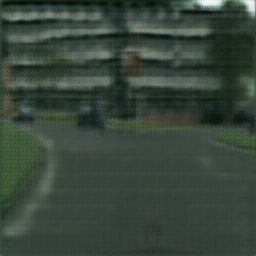

In [32]:
# Observa-se que após apenas uma época e com 400 imagens de treino já se
# encontram resultados interessantes!
gen_output = generator(inputs[0][tf.newaxis, ...], training=False)
image.array_to_img(gen_output[0, ...])

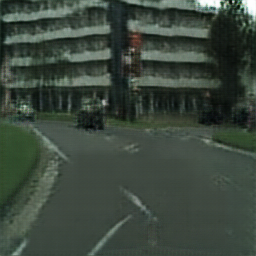

In [34]:
# Rodando mais épocas:
for j in range(5):
    for i in range(len(inputs)):
        train_step(inputs[i][tf.newaxis,...], outputs[i][tf.newaxis,...])

gen_output = generator(inputs[0][tf.newaxis, ...], training=False)
image.array_to_img(gen_output[0, ...])